In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load data
DATA_PATH = "/content/drive/MyDrive/Nhóm 1: Project_ML/Data/Processed/"

df_pca = pd.read_csv(DATA_PATH + 'data_pca30 (1).csv', index_col=0)
X_pca30 = df_pca.values


##Tính khoảng cách giữa các điểm


In [ ]:
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

def compute_distance_matrix(X):
    """Tính ma trận khoảng cách giữa tất cả các cặp điểm"""
    n = X.shape[0]
    dist_matrix = np.zeros((n, n))

    # Tính khoảng cách từng cặp
    for i in range(n):
        for j in range(i+1, n):
            dist = euclidean_distance(X[i], X[j])
            dist_matrix[i, j] = dist
            dist_matrix[j, i] = dist  # ma trận đối xứng

    return dist_matrix


## Implement Ward Linkage


In [ ]:
def compute_ward_distance(X, cluster1_indices, cluster2_indices):
    """
    Tính Ward distance giữa 2 clusters
    """
    n1 = len(cluster1_indices)
    n2 = len(cluster2_indices)

    # Tính centroid của mỗi cluster
    center1 = np.mean(X[cluster1_indices], axis=0)
    center2 = np.mean(X[cluster2_indices], axis=0)

    # Khoảng cách giữa 2 centroids
    dist_centers = euclidean_distance(center1, center2)

    # Ward distance
    ward_dist = np.sqrt((2.0 * n1 * n2) / (n1 + n2)) * dist_centers

    return ward_dist


## Hierarchical Clustering Algorithm


In [ ]:
class HierarchicalClusteringManual:
    def __init__(self, n_clusters=2):
        self.n_clusters = n_clusters
        self.labels_ = None

    def fit(self, X):
        n_samples = X.shape[0]

        # Khởi tạo - mỗi điểm là 1 cluster
        clusters = [[i] for i in range(n_samples)]
        # Track centroids for active clusters
        cluster_centroids = [X[i] for i in range(n_samples)]

        print(f"Bắt đầu với {len(clusters)} clusters (mỗi điểm 1 cluster)")

        iteration = 0
        while len(clusters) > self.n_clusters:
            iteration += 1

            min_dist = float('inf')
            merge_i, merge_j = -1, -1

            # Tìm cặp clusters có khoảng cách nhỏ nhất
            for i in range(len(clusters)):
                for j in range(i+1, len(clusters)):
                    n1 = len(clusters[i])
                    n2 = len(clusters[j])

                    center1 = cluster_centroids[i]
                    center2 = cluster_centroids[j]

                    # Ward distance
                    dist_centers = np.sqrt(np.sum((center1 - center2) ** 2))
                    ward_dist = np.sqrt((2.0 * n1 * n2) / (n1 + n2)) * dist_centers

                    if ward_dist < min_dist:
                        min_dist = ward_dist
                        merge_i = i
                        merge_j = j


            new_cluster = clusters[merge_i] + clusters[merge_j]
            new_n = len(new_cluster)


            center1 = cluster_centroids[merge_i]
            center2 = cluster_centroids[merge_j]
            new_center = (center1 * len(clusters[merge_i]) + center2 * len(clusters[merge_j])) / new_n

            if merge_i > merge_j:
                clusters.pop(merge_i)
                clusters.pop(merge_j)
                cluster_centroids.pop(merge_i)
                cluster_centroids.pop(merge_j)
            else:
                clusters.pop(merge_j)
                clusters.pop(merge_i)
                cluster_centroids.pop(merge_j)
                cluster_centroids.pop(merge_i)

            clusters.append(new_cluster)
            cluster_centroids.append(new_center)


            if iteration % 200 == 0:
                print(f"Iteration {iteration}: còn {len(clusters)} clusters, min_dist={min_dist:.4f}")

        print(f"Hoàn thành sau {iteration} iterations. Còn {len(clusters)} clusters.")

            #  Gán nhãn cho từng điểm
        self.labels_ = np.zeros(n_samples, dtype=int)
        for cluster_id, cluster_indices in enumerate(clusters):
            for idx in cluster_indices:
                self.labels_[idx] = cluster_id
        return self

    def fit_predict(self, X):
        self.fit(X)
        return self.labels_

## Tìm số clusters tối ưu


In [ ]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
wcss_scores = []
n_clusters_range = range(2, 11)

print("Bắt đầu tìm số clusters tối ưu...\n")



np.random.seed(42)
SAMPLE_SIZE = 300  # Lấy 300 mẫu để test

if X_pca30.shape[0] > SAMPLE_SIZE:
    print(f"⚠️ Dữ liệu lớn ({X_pca30.shape[0]} mẫu), đang lấy mẫu ngẫu nhiên {SAMPLE_SIZE} điểm để tìm tham số")
    sample_indices = np.random.choice(X_pca30.shape[0], SAMPLE_SIZE, replace=False)
    X_tuning = X_pca30[sample_indices]
else:
    X_tuning = X_pca30
    print("Sử dụng toàn bộ dữ liệu.")

def calculate_wcss(X, labels):
    """Tính Within-Cluster Sum of Squares (WCSS) cho Elbow method"""
    wcss = 0
    unique_labels = np.unique(labels)

    for label in unique_labels:
        cluster_points = X[labels == label]
        centroid = cluster_points.mean(axis=0)
        wcss += np.sum((cluster_points - centroid) ** 2)

    return wcss

for n in n_clusters_range:

    # Fit model trên tập sample
    hc_manual = HierarchicalClusteringManual(n_clusters=n)
    labels = hc_manual.fit_predict(X_tuning)

    # Tính silhouette score (dùng sklearn)
    score = silhouette_score(X_tuning, labels)
    silhouette_scores.append(score)

    # Tính WCSS cho Elbow method
    wcss = calculate_wcss(X_tuning, labels)
    wcss_scores.append(wcss)

    print(f"\nKết quả: Silhouette Score = {score:.4f}, WCSS = {wcss:.2f}")

    # Thống kê clusters
    unique, counts = np.unique(labels, return_counts=True)
    print("Phân bố clusters:")
    for cluster, count in zip(unique, counts):
        print(f"  Cluster {cluster}: {count} samples ({count/len(labels)*100:.1f}%)")

# Tìm số clusters tốt nhất theo Silhouette
best_n_silhouette = list(n_clusters_range)[np.argmax(silhouette_scores)]
best_score = max(silhouette_scores)


print(f"Silhouette method: Số clusters tối ưu là {best_n_silhouette}")
print(f"Silhouette Score (trên sample): {best_score:.4f}")


Bắt đầu tìm số clusters tối ưu...

⚠️ Dữ liệu lớn (801 mẫu), đang lấy mẫu ngẫu nhiên 300 điểm để tìm tham số
Bắt đầu với 300 clusters (mỗi điểm 1 cluster)
Iteration 200: còn 100 clusters, min_dist=108.9327
Hoàn thành sau 298 iterations. Còn 2 clusters.

Kết quả: Silhouette Score = 0.2797, WCSS = 5498288.90
Phân bố clusters:
  Cluster 0: 53 samples (17.7%)
  Cluster 1: 247 samples (82.3%)
Bắt đầu với 300 clusters (mỗi điểm 1 cluster)
Iteration 200: còn 100 clusters, min_dist=108.9327
Hoàn thành sau 297 iterations. Còn 3 clusters.

Kết quả: Silhouette Score = 0.2827, WCSS = 4487342.02
Phân bố clusters:
  Cluster 0: 49 samples (16.3%)
  Cluster 1: 53 samples (17.7%)
  Cluster 2: 198 samples (66.0%)
Bắt đầu với 300 clusters (mỗi điểm 1 cluster)
Iteration 200: còn 100 clusters, min_dist=108.9327
Hoàn thành sau 296 iterations. Còn 4 clusters.

Kết quả: Silhouette Score = 0.3443, WCSS = 3535774.25
Phân bố clusters:
  Cluster 0: 32 samples (10.7%)
  Cluster 1: 49 samples (16.3%)
  Cluster 2: 5

##  Vẽ Dendrogram (Biểu đồ cây phân cấp)
.

Đang tính linkage matrix cho 100 mẫu...


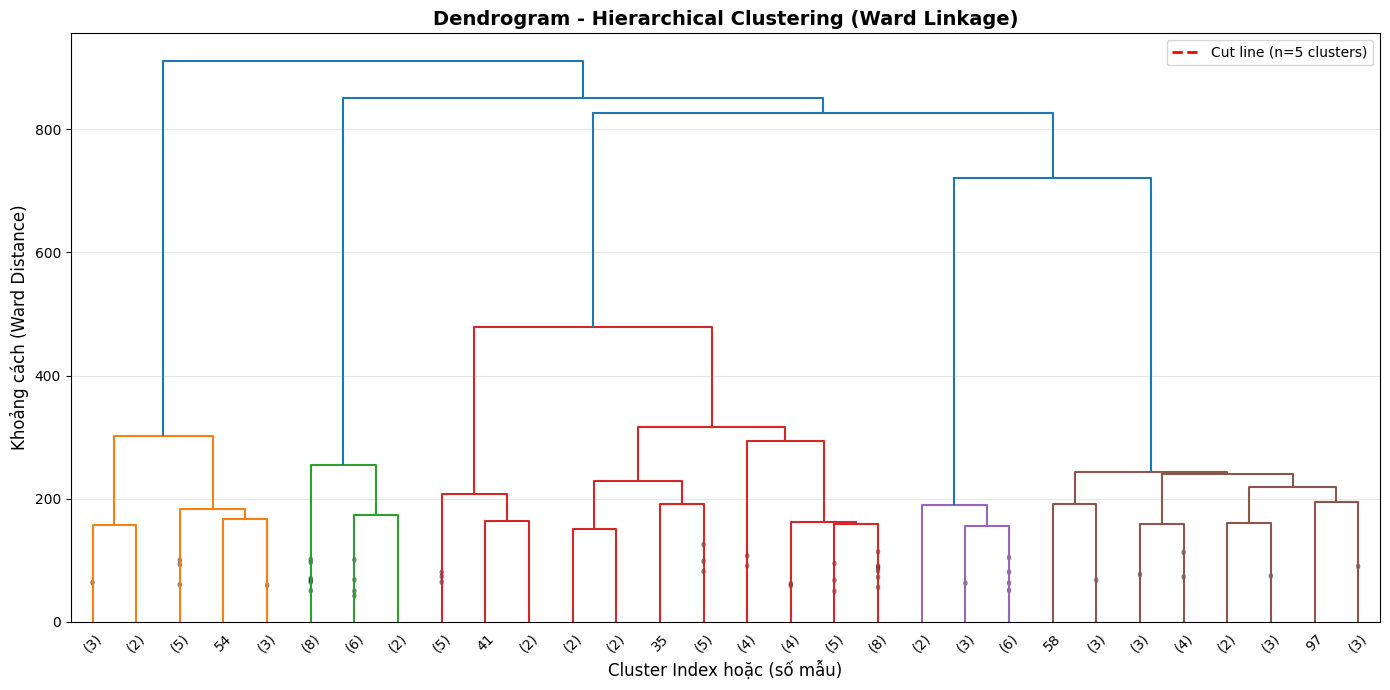


💡 Giải thích:
- Trục Y: Khoảng cách (Ward distance) khi gộp 2 cụm
- Trục X: Các mẫu hoặc nhóm mẫu
- Đường ngang đỏ: Điểm cắt để có 5 clusters
- Chiều cao càng lớn = khoảng cách giữa các cụm càng xa = nên tách thành 2 cụm riêng


In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

np.random.seed(42)
SAMPLE_SIZE_DENDRO = 100  # Lấy 100 mẫu để vẽ dendrogram cho dễ nhìn

sample_indices_dendro = np.random.choice(X_pca30.shape[0], SAMPLE_SIZE_DENDRO, replace=False)
X_dendro = X_pca30[sample_indices_dendro]

print(f"Đang tính linkage matrix cho {SAMPLE_SIZE_DENDRO} mẫu...")
# Sử dụng scipy để tạo linkage matrix với Ward method (để đối chiếu với code manual)
linkage_matrix = linkage(X_dendro, method='ward')

# Vẽ dendrogram
plt.figure(figsize=(14, 7))
dendrogram(
    linkage_matrix,
    truncate_mode='lastp',  # Chỉ hiển thị p cụm cuối cùng
    p=30,  # Hiển thị 30 cụm cuối
    leaf_font_size=10,
    show_contracted=True
)

plt.title('Dendrogram - Hierarchical Clustering (Ward Linkage)', fontsize=14, fontweight='bold')
plt.xlabel('Cluster Index hoặc (số mẫu)', fontsize=12)
plt.ylabel('Khoảng cách (Ward Distance)', fontsize=12)
plt.axhline(y=2500, color='red', linestyle='--', linewidth=2, label='Cut line (n=5 clusters)')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\n💡 Giải thích:")
print("- Trục Y: Khoảng cách (Ward distance) khi gộp 2 cụm")
print("- Trục X: Các mẫu hoặc nhóm mẫu")
print("- Đường ngang đỏ: Điểm cắt để có 5 clusters")
print("- Chiều cao càng lớn = khoảng cách giữa các cụm càng xa = nên tách thành 2 cụm riêng")

## Vẽ biểu đồ Silhouette Score

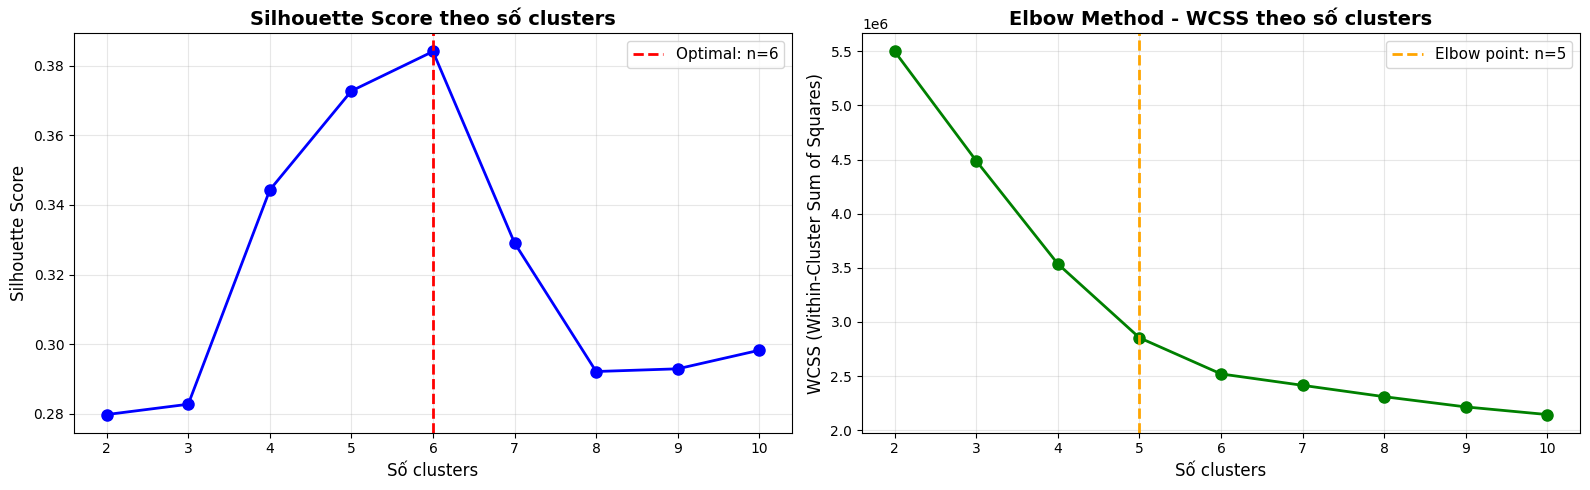


Bảng kết quả chi tiết:
------------------------------------------------------------
n_clusters      Silhouette Score     WCSS                
------------------------------------------------------------
2               0.2797               5498288.90          
3               0.2827               4487342.02          
4               0.3443               3535774.25          
5               0.3728               2853548.21           <-- ELBOW POINT
6               0.3841               2519741.78           <-- TỐI ƯU (Silhouette)
7               0.3291               2414322.08          
8               0.2921               2309444.62          
9               0.2929               2214964.39          
10              0.2982               2144257.61          
------------------------------------------------------------

📊 PHÂN TÍCH:
• Silhouette method gợi ý: n = 6
• Elbow method gợi ý: n = 5 (dựa trên gấp khúc của WCSS)
• Ground truth có: 5 nhãn thật

✅ KẾT LUẬN: Nên chọn n = 5 clusters
 

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Subplot 1: Silhouette Score
ax1.plot(list(n_clusters_range), silhouette_scores, 'bo-', linewidth=2, markersize=8)
ax1.axvline(x=best_n_silhouette, color='red', linestyle='--', linewidth=2,
            label=f'Optimal: n={best_n_silhouette}')
ax1.set_xlabel('Số clusters', fontsize=12)
ax1.set_ylabel('Silhouette Score', fontsize=12)
ax1.set_title('Silhouette Score theo số clusters', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Subplot 2: Elbow Method (WCSS)
ax2.plot(list(n_clusters_range), wcss_scores, 'go-', linewidth=2, markersize=8)
# Đánh dấu điểm gấp khúc (elbow) tại n=5
ax2.axvline(x=5, color='orange', linestyle='--', linewidth=2,
            label='Elbow point: n=5')
ax2.set_xlabel('Số clusters', fontsize=12)
ax2.set_ylabel('WCSS (Within-Cluster Sum of Squares)', fontsize=12)
ax2.set_title('Elbow Method - WCSS theo số clusters', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# In ra bảng kết quả
print("\nBảng kết quả chi tiết:")
print("-" * 60)
print(f"{'n_clusters':<15} {'Silhouette Score':<20} {'WCSS':<20}")
print("-" * 60)
for n, sil_score, wcss in zip(n_clusters_range, silhouette_scores, wcss_scores):
    marker = ""
    if n == best_n_silhouette:
        marker += " <-- TỐI ƯU (Silhouette)"
    if n == 5:
        marker += " <-- ELBOW POINT"
    print(f"{n:<15} {sil_score:<20.4f} {wcss:<20.2f}{marker}")
print("-" * 60)

print("\n📊 PHÂN TÍCH:")
print(f"• Silhouette method gợi ý: n = {best_n_silhouette}")
print(f"• Elbow method gợi ý: n = 5 (dựa trên gấp khúc của WCSS)")
print(f"• Ground truth có: 5 nhãn thật")
print(f"\n✅ KẾT LUẬN: Nên chọn n = 5 clusters")
print("   Lý do: Phù hợp với số nhãn thật, là số lẻ, và có điểm elbow rõ ràng")


##  Train model cuối cùng với số clusters tối ưu (n=5)


In [ ]:
# Chọn n=5 dựa trên phân tích Elbow method
best_n = 5

print(f"Training model cuối cùng với n_clusters = {best_n}\n")

# Train model
final_model = HierarchicalClusteringManual(n_clusters=best_n)
final_labels = final_model.fit_predict(X_pca30)

# Tính metrics (dùng sklearn)
final_silhouette = silhouette_score(X_pca30, final_labels)


print("KẾT QUẢ CUỐI CÙNG")
print(f"Số clusters: {best_n}")
print(f"Silhouette Score: {final_silhouette:.4f}")
print(f"Tổng số mẫu: {len(final_labels)}")
print("\nPhân bố các clusters:")


unique, counts = np.unique(final_labels, return_counts=True)
for cluster, count in zip(unique, counts):
    percentage = count / len(final_labels) * 100
    print(f"Cluster {cluster}: {count:5d} samples ({percentage:5.2f}%)")



Training model cuối cùng với n_clusters = 5

Bắt đầu với 801 clusters (mỗi điểm 1 cluster)
Iteration 200: còn 601 clusters, min_dist=60.6870
Iteration 400: còn 401 clusters, min_dist=80.8262
Iteration 600: còn 201 clusters, min_dist=117.9112
Hoàn thành sau 796 iterations. Còn 5 clusters.
KẾT QUẢ CUỐI CÙNG
Số clusters: 5
Silhouette Score: 0.3699
Tổng số mẫu: 801

Phân bố các clusters:
Cluster 0:    77 samples ( 9.61%)
Cluster 1:   136 samples (16.98%)
Cluster 2:   140 samples (17.48%)
Cluster 3:   146 samples (18.23%)
Cluster 4:   302 samples (37.70%)


## Lưu kết quả

In [ ]:
# Lưu labels
df_labels = pd.DataFrame(final_labels, index=df_pca.index, columns=['hierarchical_manual'])
output_path = DATA_PATH + 'hierarchical_manual_labels.csv'
df_labels.to_csv(output_path)

print(f"Đã lưu kết quả vào: {output_path}")
print(f"Shape: {df_labels.shape}")
print("\nMẫu dữ liệu:")
print(df_labels.head(10))

Đã lưu kết quả vào: /content/drive/MyDrive/Nhóm 1: Project_ML/Data/Processed/hierarchical_manual_labels.csv
Shape: (801, 1)

Mẫu dữ liệu:
          hierarchical_manual
sample_0                    1
sample_1                    2
sample_2                    1
sample_3                    1
sample_4                    4
sample_5                    1
sample_6                    3
sample_7                    1
sample_8                    4
sample_9                    1


##  Visualization - Vẽ clusters trên PC1 và PC2

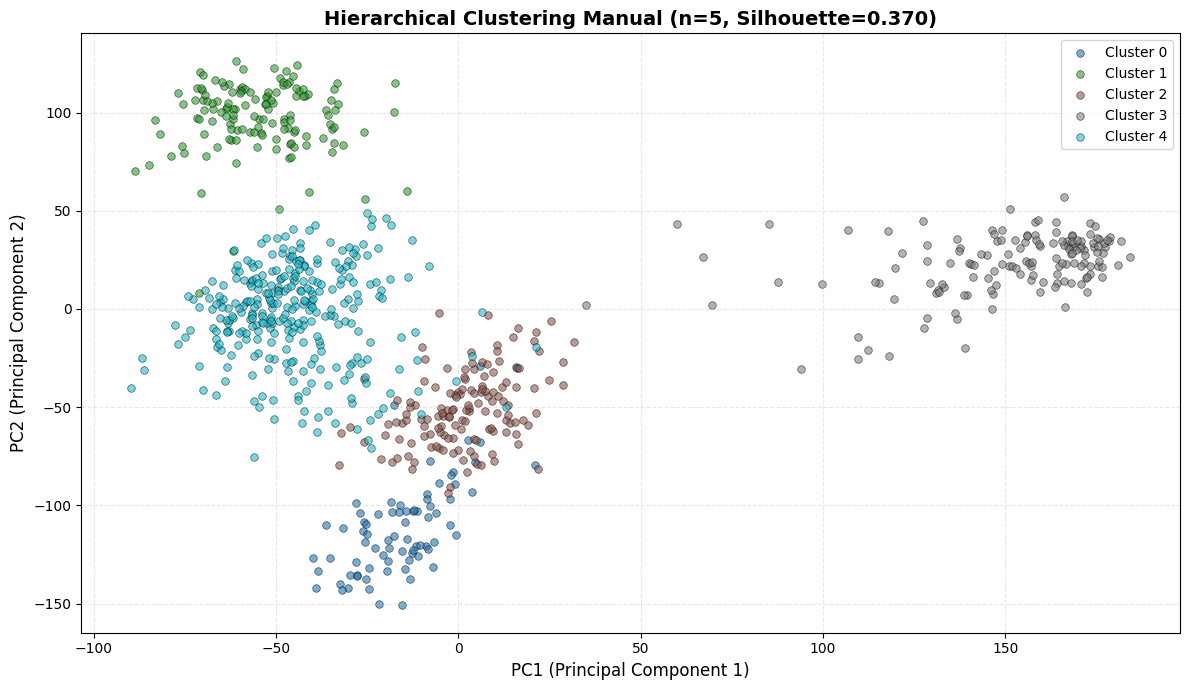

In [ ]:
# Định nghĩa màu sắc cho từng cluster
colors = plt.cm.tab10(np.linspace(0, 1, best_n))

plt.figure(figsize=(12, 7))

for i in range(best_n):
    cluster_points = X_pca30[final_labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                c=[colors[i]], label=f'Cluster {i}',
                alpha=0.6, s=30, edgecolors='black', linewidth=0.5)

plt.xlabel('PC1 (Principal Component 1)', fontsize=12)
plt.ylabel('PC2 (Principal Component 2)', fontsize=12)
plt.title(f'Hierarchical Clustering Manual (n={best_n}, Silhouette={final_silhouette:.3f})',
          fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# 1. Load nhãn thật từ
df_true_labels = pd.read_csv("/content/drive/MyDrive/Nhóm 1: Project_ML/Data/Raw/labels.csv", index_col=0)

# Đảm bảo index khớp nhau giữa data training và nhãn
# (Giả sử thứ tự mẫu trong X_pca30 khớp với labels.csv, nếu không cần merge theo index)
y_true = df_true_labels['Class'].values

# 2. Tính toán độ chính xác so với nhãn thật
ari_score = adjusted_rand_score(y_true, final_labels)
nmi_score = normalized_mutual_info_score(y_true, final_labels)

print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi_score:.4f}")

Adjusted Rand Index (ARI): 0.9907
Normalized Mutual Information (NMI): 0.9860
